In [1]:
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm_notebook
import pandas as pd
from sklearn.metrics import mean_squared_error
import scipy

In [2]:
feature_matrix = np.load('new_feature_matrix.npy')
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
cuda = True if torch.cuda.is_available() else False
drop_rate = 0.5
time_step = 5
epochs = 200
feature_matrix = np.load('new_feature_matrix.npy')

In [3]:
scaler = StandardScaler()
## normalization
def normalization(feature_matrix):
    feature_mat = np.zeros((feature_matrix.shape[0],feature_matrix.shape[1],feature_matrix.shape[2]))
    target = np.zeros((feature_matrix.shape[0],feature_matrix.shape[1]))
    for i in range(feature_matrix.shape[0]):
        feature_vector=feature_matrix[i]
        f1 = scaler.fit_transform(feature_vector[:,0].reshape(-1,1)).reshape(-1,1)
        f2 = scaler.fit_transform(feature_vector[:,1].reshape(-1,1)).reshape(-1,1)
        f3 = scaler.fit_transform(feature_vector[:,2].reshape(-1,1)).reshape(-1,1)
        f4 = scaler.fit_transform(feature_vector[:,3].reshape(-1,1)).reshape(-1,1)
        visit_nums = scaler.fit_transform(feature_vector[:,4].reshape(-1,1)).reshape(-1,1)
        feature_vector = np.stack([f1,f2,f3,f4,visit_nums],axis=1).reshape(feature_matrix.shape[1],feature_matrix.shape[2])
        feature_mat[i] = feature_vector
    return feature_mat


## split into train, test and validation
features = feature_matrix
features = normalization(features)
train_idx, test_idx, val_idx = [],[],[]
for i in range(features.shape[0]):
    if i%5<=2:
        train_idx.append(i)
    elif i%5==3:
        val_idx.append(i)
    else:
        test_idx.append(i)

train_features = features[train_idx,:,:]
test_features = features[test_idx,:,:]
val_features = features[val_idx,:,:]

In [4]:
print(val_features.shape)
print(test_features.shape)
print(train_features.shape)

(18, 172, 5)
(18, 172, 5)
(54, 172, 5)


In [5]:
def get_features(features, index):
    f = features[:,index,:].cpu()
    new = np.zeros((len(f) - time_step, time_step, 4-1))
    target = np.zeros((len(f) - time_step, 1))
    for i in range(len(f) - time_step):
        new[i] = f[i:i+time_step,1:4]
        target[i] = f[i+time_step, 4]
    return new, target

# LSTM(Long Short Term Memory)

In [6]:
class MLP(torch.nn.Module):
    def __init__(self, n_i, n_h, n_o):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(n_i, n_h)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(n_h, n_o)
    def forward(self, input):
        input = self.linear1(input)
        input = self.relu(input)
        input = F.dropout(input, p=drop_rate, training=self.training)
        input = self.linear2(input)
        return input
###Convert the data to tensor 
def totensor(data):
    return torch.Tensor(data).to(device)

class LSTM(nn.Module):
    def __init__(self):
        super(LSTM,self).__init__()
        self.mlp = MLP(time_step*4,32,1)#input is the num of time_step
        self.lstm1 = nn.LSTM(input_size=3,hidden_size=128,num_layers=2,batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128,hidden_size=4,num_layers=2,batch_first=True)
    def forward(self, x):
        x1,x2,x3 = x.size()
        h1, (h1_T,c1_T) = self.lstm1(x)
        h2, (h2_T, c2_T) = self.lstm2(h1)
        h2 = h2.reshape(x1,-1)
        output= self.mlp(h2)
        return output 

In [7]:
min_val_loss = np.inf
mean_losses = []
losses = pd.DataFrame(columns = ['Training Loss', 'Validating Loss','Testing Loss'])
model = LSTM().cpu()
loss = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(),lr=0.001)

In [8]:
for epoch in tqdm_notebook(range(1, epochs + 1)):
    mean_loss, n = 0.0 , train_features.shape[1]
    train_mean_loss, test_mean_loss = 0, 0
    for i in range(n):
      # Tensor.cpu()
        train, train_target = get_features(totensor(train_features), i)
        train, train_target = totensor(train), totensor(train_target)
        val, val_target = get_features(totensor(val_features), i)
        val, val_target = totensor(val), totensor(val_target)
        y_train, y_val = model(train), model(val)
        train_loss, val_loss = loss(y_train, train_target), loss(y_val, val_target)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        losses.loc[i,'Training Loss'], losses.loc[i,'Validating Loss'] = train_loss.detach().cpu().numpy(), val_loss.detach().cpu().numpy()
    train_loss, val_loss = losses['Training Loss'].mean(), losses['Validating Loss'].mean()
    mean_losses.append((train_loss, val_loss))
    if train_loss < min_val_loss:
        min_val_loss = train_loss
    print('Epoch: {:03d} | Lr: {:.20f} |Train loss: {:.8f}|Val loss: {:.8f}'.\
          format(epoch, optimizer.param_groups[0]['lr'], min_val_loss, val_loss))

print('\nTraining finished.\n')

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 001 | Lr: 0.00100000000000000002 |Train loss: 0.97902129|Val loss: 0.97725039
Epoch: 002 | Lr: 0.00100000000000000002 |Train loss: 0.97902129|Val loss: 1.06955657
Epoch: 003 | Lr: 0.00100000000000000002 |Train loss: 0.97902129|Val loss: 1.03805329
Epoch: 004 | Lr: 0.00100000000000000002 |Train loss: 0.97902129|Val loss: 1.02975712
Epoch: 005 | Lr: 0.00100000000000000002 |Train loss: 0.97902129|Val loss: 1.02792758
Epoch: 006 | Lr: 0.00100000000000000002 |Train loss: 0.97902129|Val loss: 1.02224891
Epoch: 007 | Lr: 0.00100000000000000002 |Train loss: 0.97902129|Val loss: 1.02254380
Epoch: 008 | Lr: 0.00100000000000000002 |Train loss: 0.97902129|Val loss: 1.01810571
Epoch: 009 | Lr: 0.00100000000000000002 |Train loss: 0.97902129|Val loss: 1.01010389
Epoch: 010 | Lr: 0.00100000000000000002 |Train loss: 0.97902129|Val loss: 1.03907181
Epoch: 011 | Lr: 0.00100000000000000002 |Train loss: 0.97902129|Val loss: 1.01948414
Epoch: 012 | Lr: 0.00100000000000000002 |Train loss: 0.97902129|V

Epoch: 098 | Lr: 0.00100000000000000002 |Train loss: 0.58552986|Val loss: 0.58415377
Epoch: 099 | Lr: 0.00100000000000000002 |Train loss: 0.58552986|Val loss: 0.64607846
Epoch: 100 | Lr: 0.00100000000000000002 |Train loss: 0.58552986|Val loss: 0.65892193
Epoch: 101 | Lr: 0.00100000000000000002 |Train loss: 0.58552986|Val loss: 0.71002725
Epoch: 102 | Lr: 0.00100000000000000002 |Train loss: 0.58552986|Val loss: 0.61647881
Epoch: 103 | Lr: 0.00100000000000000002 |Train loss: 0.58314346|Val loss: 0.59367557
Epoch: 104 | Lr: 0.00100000000000000002 |Train loss: 0.58314346|Val loss: 0.62552798
Epoch: 105 | Lr: 0.00100000000000000002 |Train loss: 0.58314346|Val loss: 0.61068970
Epoch: 106 | Lr: 0.00100000000000000002 |Train loss: 0.58314346|Val loss: 0.64920142
Epoch: 107 | Lr: 0.00100000000000000002 |Train loss: 0.57945016|Val loss: 0.57950907
Epoch: 108 | Lr: 0.00100000000000000002 |Train loss: 0.56813276|Val loss: 0.53956928
Epoch: 109 | Lr: 0.00100000000000000002 |Train loss: 0.56813276|V

Epoch: 195 | Lr: 0.00100000000000000002 |Train loss: 0.46256717|Val loss: 0.48672379
Epoch: 196 | Lr: 0.00100000000000000002 |Train loss: 0.46256717|Val loss: 0.46526585
Epoch: 197 | Lr: 0.00100000000000000002 |Train loss: 0.46256717|Val loss: 0.47299758
Epoch: 198 | Lr: 0.00100000000000000002 |Train loss: 0.46256717|Val loss: 0.59375413
Epoch: 199 | Lr: 0.00100000000000000002 |Train loss: 0.46256717|Val loss: 0.56298677
Epoch: 200 | Lr: 0.00100000000000000002 |Train loss: 0.46256717|Val loss: 0.46177416

Training finished.



In [9]:
test_loss = []
for i in range(n):
    test, test_target = get_features(totensor(test_features), i)
    test, test_target = totensor(test), totensor(test_target)
    test_y = model(test)
    # val_y = model(val)
    test_loss.append(loss(test_target,test_y).detach().cpu().numpy())
# print('Test loss: {:.8f}'.\
#       format())
# nn.MSELoss(test_y.detach().flatten(),test_target.flatten())
# test_y

In [10]:
print(np.array(test_loss).mean())
mean_losses = np.array(mean_losses)

0.4243385


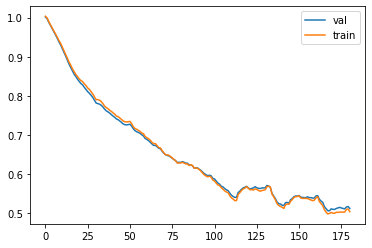

In [11]:
t_lose = [x for x in np.convolve(mean_losses[:,0], np.ones(20), 'valid') / 20]
v_lose = [x for x in np.convolve(mean_losses[:,1], np.ones(20), 'valid') / 20]
plt.figure(facecolor='white')
plt.plot(t_lose,label = 'val')
plt.plot(v_lose,label = 'train')
plt.legend()
#plt.title('LSTM Training Curve')
plt.show()

In [12]:
eva_set =np.zeros((n,2))
for i in range(n):
    test, test_target = get_features(totensor(test_features), i)
    test = totensor(test)
    y_test =  model(test).detach().cpu().numpy().reshape(-1)[-1]
    test_target = test_target.reshape(-1)[-1]
    eva_set[i] = np.array([test_target,y_test])
    
scipy.stats.pearsonr(eva_set[:,0],eva_set[:,1])[0],mean_squared_error(eva_set[:,0],eva_set[:,1])

(0.7867004435134238, 0.397311218343)

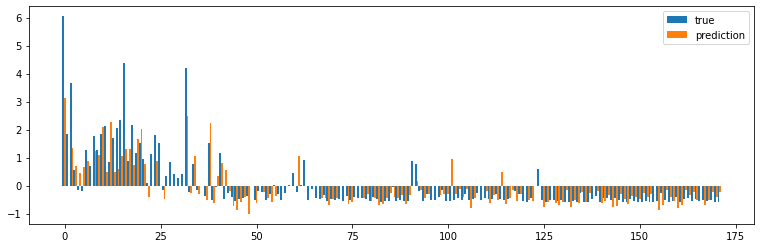

In [13]:
a = eva_set[:,0]
p = eva_set[:,1]
plt.figure(figsize = (13,4),facecolor='white')
xxx = np.arange(len(p))

plt.bar(xxx-0.5,a[xxx],0.5,label = 'true')
plt.bar(xxx,p[xxx],0.5,label = 'prediction')
plt.legend()
#plt.title('LSTM Prediction')
plt.show()

# Linear Regressor

In [14]:
import statsmodels.api as sm
n = train_features.shape[1]
new_train_feature = np.zeros((train_features.shape[0]*n,train_features.shape[2]+1))
for i in range(n):
    new_train_feature[train_features.shape[0]*i:train_features.shape[0]*(i+1)] = np.hstack((train_features[:,i,:],np.array([[i]]*train_features.shape[0])))
train = pd.DataFrame(new_train_feature)
train[5] = train[5].astype('category')
X_train,Y_train = train.iloc[:,[0,1,2,3,5]],train.iloc[:,4]
X_train = pd.get_dummies(data=X_train, drop_first=True)

In [15]:
X_train.shape

(9288, 175)

In [16]:
new_test_feature = np.zeros(((test_features.shape[0]+val_features.shape[0])*n,(test_features.shape[2])+1))
for i in range(n):
    new_test_feature[test_features.shape[0]*i:test_features.shape[0]*(i+1)] = np.hstack((test_features[:,i,:],np.array([[i]]*test_features.shape[0])))
    new_test_feature[test_features.shape[0]*n + val_features.shape[0]*i:test_features.shape[0]*n + val_features.shape[0]*(i+1)] = np.hstack((val_features[:,i,:],np.array([[i]]*val_features.shape[0])))
test = pd.DataFrame(new_test_feature)
test[5] = test[5].astype('category')
X_test,Y_test = test.iloc[:,[0,1,2,3,5]],test.iloc[:,4]
X_test = pd.get_dummies(data=X_test, drop_first=True)

In [17]:
X2 = sm.add_constant(X_train)
est = sm.OLS(Y_train,X2)
est2 = est.fit_regularized(L1_wt = .5,alpha = .1)
from sklearn.linear_model import LinearRegression
X_train = X_train.values
Y_train = Y_train.values

model = LinearRegression()
model.fit(X_train,Y_train)

LinearRegression()

In [18]:
XX = sm.add_constant(X_test)
pred_y = est2.predict(XX)
scipy.stats.pearsonr(Y_test,pred_y)[0],mean_squared_error(Y_test,pred_y)
# pred_y

(0.8340322307603375, 0.3114301129767445)

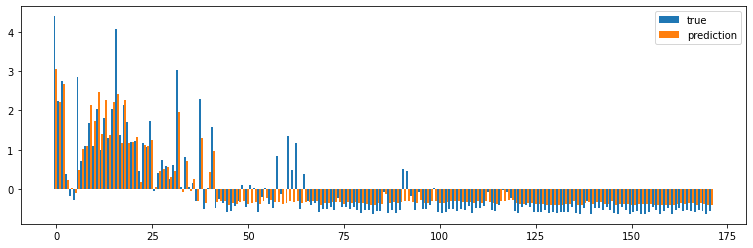

In [19]:
a = np.array(Y_test[:3096]).reshape((172,-1),order = 'A').mean(axis = 1 )
p = np.array(pred_y[:3096]).reshape((172,-1),order = 'A').mean(axis = 1 )
plt.figure(figsize = (13,4),facecolor='white')
xxx = np.arange(len(p))

plt.bar(xxx-0.5,a[xxx],0.5,label = 'true')
plt.bar(xxx,p[xxx],0.5,label = 'prediction')
plt.legend()
#plt.title('Linear Regression Prediction')
plt.show()

# AR (Autoregressive Model)

In [20]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
train_series = train_features[:,:,4].T
test_series = test_features[:,:,4].T
val_series = val_features[:,:,4].T
train_series.shape

(172, 54)

In [21]:
ar_models = []
for i in range(n):
    ar_model = AutoReg(train_series[i], lags=5).fit()
    ar_models.append(ar_model)
test_series.shape

(172, 18)

In [22]:
ar_pred = []
for i in range(n):
    pred = ar_models[i].predict(start=train_series.shape[1]+val_series.shape[1]+1,
                              end=(train_series.shape[1]+test_series.shape[1]+val_series.shape[1]), dynamic=False)
    ar_pred.append(pred)
ar_pred = np.array(ar_pred)

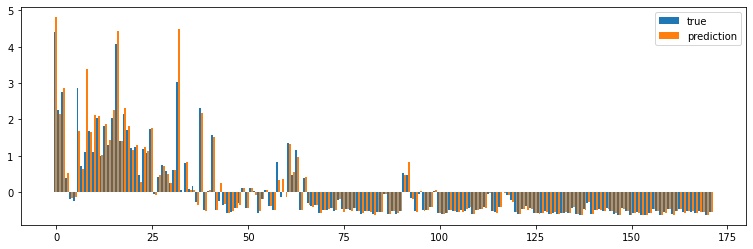

In [23]:
a = test_series.mean(axis=1)
p = ar_pred.mean(axis=1)
plt.figure(figsize = (13,4),facecolor='white')
xxx = np.arange(len(p))

plt.bar(xxx-0.5,a[xxx],0.5,label = 'true')
plt.bar(xxx,p[xxx],0.5,label = 'prediction')
plt.legend()
#plt.title('AR Prediction')
plt.show()

In [24]:
print(ar_pred.shape)
print(test_series.shape)

(172, 18)
(172, 18)


In [25]:
pred_y = ar_pred.flatten()
actual_y = test_series.flatten()
scipy.stats.pearsonr(pred_y,actual_y)[0],mean_squared_error(pred_y,actual_y)

(0.9010039860963176, 0.20195191740444982)

# HA (Naive Approach)

In [26]:
HA_pred = np.zeros((n,4))
for i in range(n):
    for k in range(3):
        HA_pred[i][k] = (np.sum(train_series[i,-(3-k)])+np.sum(HA_pred[i]))/4
    HA_pred[i][3] = sum(HA_pred[i])/4
pred_y = HA_pred.flatten()
actual_y = np.array([x[-4:] for x in val_series]).flatten()

In [27]:
scipy.stats.pearsonr(pred_y,actual_y)[0],mean_squared_error(pred_y,actual_y)

(0.9518003729199354, 0.5151370420798731)

In [28]:
a = actual_y.reshape((172,-1)).mean(axis = 1)
p = pred_y.reshape((172,-1)).mean(axis = 1)

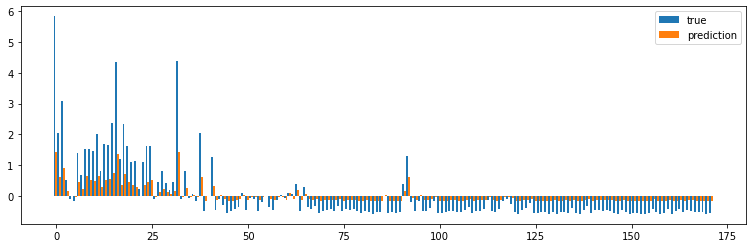

In [29]:
a = actual_y.reshape((172,-1)).mean(axis = 1)
p = pred_y.reshape((172,-1)).mean(axis = 1)
plt.figure(figsize = (13,4),facecolor='white')
xxx = np.arange(len(p))

plt.bar(xxx-0.5,a[xxx],0.5,label = 'true')
plt.bar(xxx,p[xxx],0.5,label = 'prediction')
plt.legend()
#plt.title('HA Prediction')
plt.show()

In [ ]:
pd.DataFrame({"ss":[12.32]})